In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_color_map
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import torch
from torch import nn, optim, utils
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import models
import numpy as np
import os
import shutil
import time
from tqdm import tqdm
import copy
from tensorboardX import SummaryWriter
from torchsummary import summary
from PIL import Image

In [2]:
data_dir = '/home/samael/github/image_generation/'
worker = 8
batch_size = 32
image_size = 256
num_epochs = 25
lr = 1e-2
momentum = 0.9
ngpu = 1
writer = SummaryWriter(log_dir='log')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'raw': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: vdatasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'raw']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=worker) for x in ['train', 'raw']}
print('Initialized!')

Initializing Datasets and Dataloaders...
Initialized!


In [4]:
device = torch.device('cuda:0')

In [5]:
def norm_image(image):
    min_val = torch.min(image)
    max_val = torch.max(image)
    return (image - min_val) / (max_val - min_val)

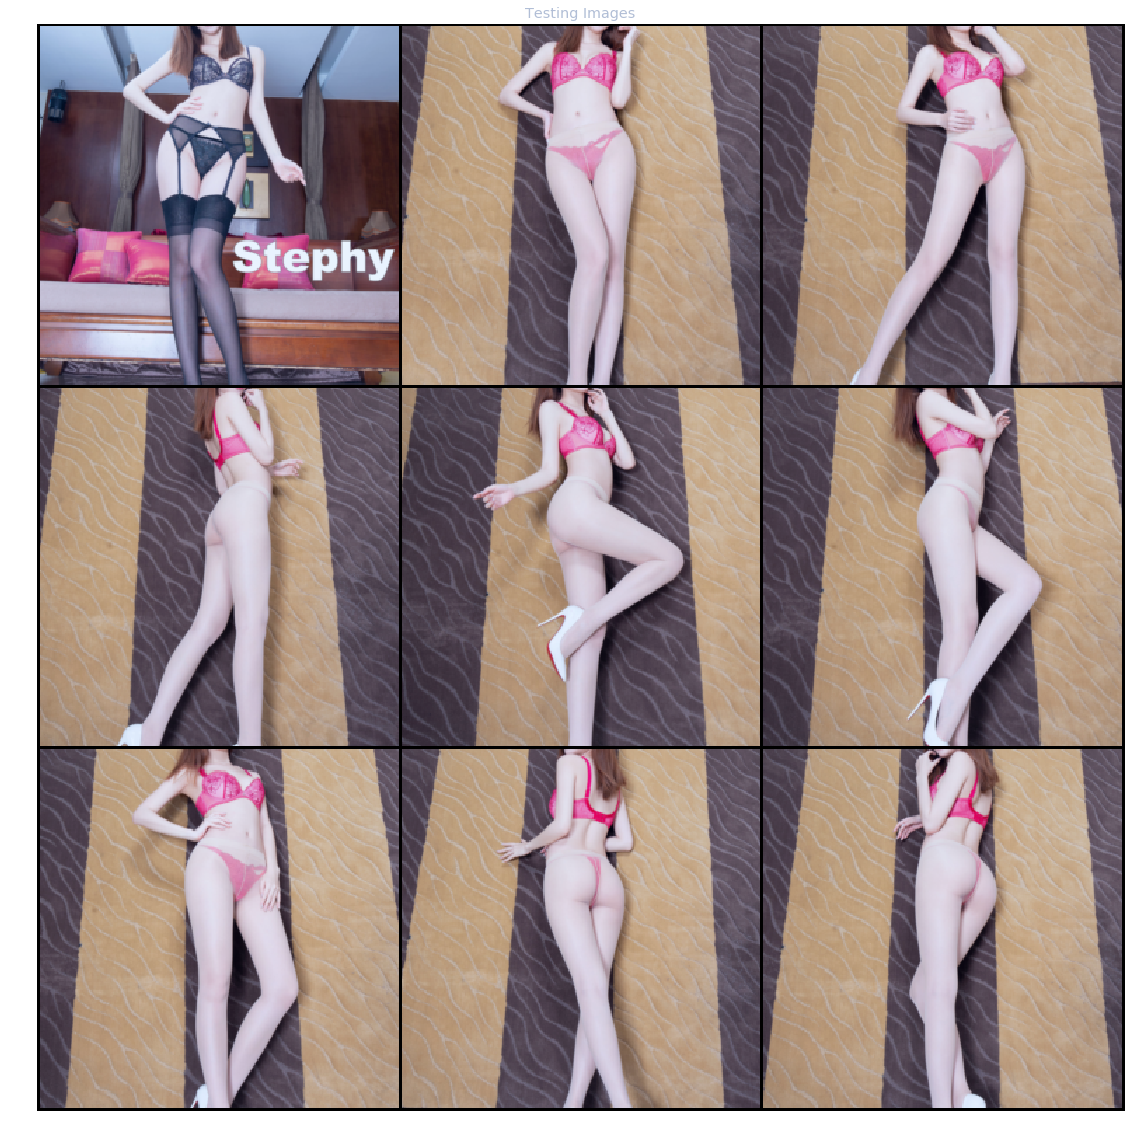

In [6]:
real_batch = next(iter(dataloaders_dict['train']))
test_batch = next(iter(dataloaders_dict['raw']))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:9], padding=2, normalize=True, nrow=3).cpu(),(1,2,0)))
plt.show()

In [7]:
resnet50 = models.resnet50(pretrained=False)
resnet50.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet50.fc = nn.Linear(512 * 4, 9)
resnet50.load_state_dict(torch.load('stocking_classification.pth'))
resnet50.eval()
resnet50 = resnet50.to(device)
# summary(resnet50, (3, 512, 512))
if ngpu > 1:
    resnet50 = nn.DataParallel(resnet50, list(range(ngpu)))

In [8]:
classes = ['black_tights', 'boots', 'fishnet', 'flesh_colored',
           'other_colors', 'others', 'pants', 'pattern', 'white_tights']

In [9]:
index = 1
for inputs, _ in tqdm(dataloaders_dict['raw'], total=len(dataloaders_dict['raw'].dataset) // batch_size + 1):
    inputs = inputs.to(device)
    outputs = resnet50(inputs)
    prob, pred = torch.max(F.softmax(outputs, dim=1), 1)
    for i in range(inputs.shape[0]):
        if not os.path.exists(os.path.join('beautyleg_classificated/', classes[pred[i]])):
            os.mkdir(os.path.join(
                'beautyleg_classificated/', classes[pred[i]]))
        if prob[i] >= 0.99:
            try:
                shutil.copy(os.path.join('raw/beautyleg_sorted/', str(index).zfill(5)+'.jpg'),
                            os.path.join('beautyleg_classificated/', classes[pred[i]]))
            except:
                print(str(index).zfill(5)+'.jpg')
        else:
            try:
                shutil.copy(os.path.join('raw/beautyleg_sorted/', str(index).zfill(5)+'.jpg'),
                            'beautyleg_unclassificated/')
            except:
                print(str(index).zfill(5)+'.jpg')
        index += 1

 19%|█▉        | 490/2580 [04:52<25:31,  1.36it/s]  

15634.jpg


 43%|████▎     | 1118/2580 [11:11<07:55,  3.08it/s]

35737.jpg


 93%|█████████▎| 2390/2580 [22:21<00:50,  3.73it/s]

76430.jpg
76431.jpg
76432.jpg
76433.jpg
76434.jpg
76435.jpg
76436.jpg
76437.jpg
76438.jpg
76439.jpg
76440.jpg
76441.jpg


100%|██████████| 2580/2580 [23:15<00:00,  1.85it/s]
